In [2]:
import numpy as np
import pandas as pd 
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns
sns.set(font='SimHei')
sns.set_palette('muted')
sns.set_style('dark')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
path = 'C:/test/work/ppd/data'

# 用户数据表

In [15]:
# 导入data_EDA_clean处理过的数据
data1 = pd.read_csv(path+'/data1_clean.csv',encoding='gbk')

In [16]:
cat = data1.select_dtypes(include='O').columns
num = data1.select_dtypes(exclude='O').columns

In [3]:
# 导入变量明细表
var_info = pd.read_csv('var_info.csv',encoding='gbk')

In [4]:
base_col = list(data1.columns)
var_info2 = var_info[var_info.变量名称.isin(base_col)].reset_index(drop=True)
var_info2.变量类型.value_counts() 

Numerical      125
Categorical     20
Index            1
Name: 变量类型, dtype: int64

## 类别型变量 

In [8]:
# 数值型类别变量的desc
data1.loc[:,cat].describe().T.assign(
    nuniq = data1.loc[:,cat].apply(
    lambda x:x.nunique()),
    missing_pct = data1.loc[:,cate].apply(lambda x:(len(x)-x.count())/len(x)))

,count,unique,top,freq,nuniq,missing_pct
UserInfo_19,49101,31,山东省,3928,31,0.000000
UserInfo_2,48654,329,深圳,1226,329,0.009104
UserInfo_20,49101,308,不详,11718,308,0.000000
UserInfo_4,48708,332,深圳,1382,332,0.008004
UserInfo_7,49101,32,不详,6893,32,0.000000
UserInfo_8,49101,664,不详,6893,664,0.000000
UserInfo_9,49101,7,中国移动,25381,7,0.000000
WeblogInfo_19,44682,7,I,36209,7,0.089998
WeblogInfo_20,36311,38,I5,18422,38,0.260483
WeblogInfo_21,44528,4,D,35733,4,0.093135


In [9]:
# 先对所有字符型变量作去空格处理
for col in cat:
    data1[col] = data1[col].map(lambda x:str(x).strip())

### 省份

In [19]:
# 计算各省份违约率
def plot_pro_badrate(df,col):
    group = df.groupby(col)
    df = pd.DataFrame()
    df['total'] = group['target'].count()
    df['bad'] = group['target'].sum()
    df['badrate'] = df['bad']/df['total']
    # 筛选出违约率排名前5的省份
    print(df.sort_values('badrate',ascending=False).iloc[:5,:])

In [20]:
# 户籍地址
plot_pro_badrate(data1,'UserInfo_19')

             total    bad   badrate
UserInfo_19                        
西藏自治区            5    1.0  0.200000
天津市            215   24.0  0.111628
山东省           3928  421.0  0.107179
四川省           3105  292.0  0.094042
吉林省            842   78.0  0.092637


In [21]:
# 西藏自治区的人数太少，不具有参考价值，剔除后再计算
plot_pro_badrate(data1[~(data1.UserInfo_19=='西藏自治区')],'UserInfo_19')

             total    bad   badrate
UserInfo_19                        
天津市            215   24.0  0.111628
山东省           3928  421.0  0.107179
四川省           3105  292.0  0.094042
吉林省            842   78.0  0.092637
黑龙江省          1326  119.0  0.089744


In [22]:
# 居住地址
plot_pro_badrate(data1,'UserInfo_7')

            total    bad   badrate
UserInfo_7                        
山东           3413  374.0  0.109581
四川           1902  206.0  0.108307
天津            306   31.0  0.101307
湖南           1779  176.0  0.098932
吉林            507   49.0  0.096647


In [23]:
# 户籍省份的二值化衍生
data1['is_tianjin_userinfo19'] = data1.apply(lambda x:1 if x.UserInfo_19=='天津市' else 0,axis=1)
data1['is_shandong_userinfo19'] = data1.apply(lambda x:1 if x.UserInfo_19=='山东省' else 0,axis=1)
data1['is_jilin_userinfo19'] = data1.apply(lambda x:1 if x.UserInfo_19=='吉林省' else 0,axis=1)
data1['is_sichuan_userinfo19'] = data1.apply(lambda x:1 if x.UserInfo_19=='四川省' else 0,axis=1)
data1['is_heilongj_userinfo19'] = data1.apply(lambda x:1 if x.UserInfo_19=='黑龙江省' else 0,axis=1)

# 居住地址省份的二值化衍生
data1['is_tianjin_userinfo7'] = data1.apply(lambda x:1 if x.UserInfo_7=='天津' else 0,axis=1)
data1['is_shandong_userinfo7'] = data1.apply(lambda x:1 if x.UserInfo_7=='山东' else 0,axis=1)
data1['is_sichuan_userinfo7'] = data1.apply(lambda x:1 if x.UserInfo_7=='四川' else 0,axis=1)
data1['is_hunan_userinfo7'] = data1.apply(lambda x:1 if x.UserInfo_7=='湖南' else 0,axis=1)
data1['is_jilin_userinfo7'] = data1.apply(lambda x:1 if x.UserInfo_7=='吉林' else 0,axis=1)

In [24]:
# 户籍省份和居住地省份不一致衍生
data1.UserInfo_19.unique()

array(['四川省', '福建省', '湖北省', '江西省', '辽宁省', '山东省', '内蒙古自治区', '湖南省', '黑龙江省',
       '山西省', '江苏省', '云南省', '浙江省', '广东省', '天津市', '广西壮族自治区', '甘肃省', '贵州省',
       '陕西省', '重庆市', '河北省', '青海省', '安徽省', '上海市', '吉林省', '北京市', '河南省',
       '宁夏回族自治区', '新疆维吾尔自治区', '海南省', '西藏自治区'], dtype=object)

In [25]:
data1.UserInfo_7.unique()

array(['广东', '浙江', '湖北', '福建', '辽宁', '不详', '内蒙古', '湖南', '黑龙江', '山西', '北京',
       '山东', '江苏', '云南', '天津', '广西', '重庆', '江西', '四川', '陕西', '贵州', '河北',
       '青海', '甘肃', '安徽', '吉林', '新疆', '海南', '河南', '宁夏', '上海', '西藏'],
      dtype=object)

In [27]:
# 将UserInfo_19改成和居住地址省份相同的格式
UserInfo_19_change = []
for i in data1.UserInfo_19:
    if i=='内蒙古自治区' or i=='黑龙江省':
        j = i[:3]
    else:
        j=i[:2]
    UserInfo_19_change.append(j)

In [28]:
is_same_province=[]
# 判断UserInfo_7和UserInfo_19是否一致
for i,j in zip(data1.UserInfo_7,UserInfo_19_change):
    if i==j:
        a = 1
    else:
        a = 0
    is_same_province.append(a)
    
data1['is_same_province'] = is_same_province

# 删除原有的变量
data1 = data1.drop(['UserInfo_19','UserInfo_7'],axis=1)
data1.shape

(49101, 158)

### 运营商

In [29]:
# 将运营商信息转换为哑变量
data1 = data1.replace({'UserInfo_9':{'中国移动':'china_mobile',
                                     '中国电信':'china_telecom',
                                     '中国联通':'china_unicom',
                                     '不详':'operator_unknown'}})
oper_dummy = pd.get_dummies(data1.UserInfo_9)
data1 = pd.concat([data1,oper_dummy],axis=1)
# 删除原变量
data1 = data1.drop(['UserInfo_9'],axis=1)
data1.shape

(49101, 164)

###  城市

In [30]:
# 计算4个城市特征的非重复项计数，观察是否有数据异常
for col in ['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']:
    print('{}:{}'.format(col,data1[col].nunique()))
    print('\t')

UserInfo_2:329
	
UserInfo_4:332
	
UserInfo_8:664
	
UserInfo_20:308
	


In [31]:
# UserInfo_8相对其他特征nunique较大，发现有些城市有"市"，有些没有，需要做一下清洗
print(data1.UserInfo_8.unique()[:50])

['深圳' '温州' '宜昌' '南平' '辽阳' '不详' '包头' '广州' '赤峰' '鄂州' '武汉' '长沙' '漳州' '牡丹江'
 '太原市' '北京' '忻州' '三明' '临沂' '福州' '泰州市' '大同' '红河' '郴州' '常州' '湖州' '佛山' '天津'
 '南宁' '聊城' '柳州' '广州市' '太原' '重庆' '杭州' '景德镇' '上饶' '鸡西' '资阳' '成都' '济宁' '滨州'
 '渭南' '都匀' '廊坊' '西宁市' '金华' '龙岩' '清远' '兰州']


In [32]:
# UserInfo_8清洗处理，处理后非重复项计数减小到400
data1['UserInfo_8']=[s[:-1] if s.find('市')>0 else s[:] for s in data1.UserInfo_8] 
data1.UserInfo_8.nunique()

400

In [33]:
# 根据xgboost变量重要性的输出吧对城市作二值化衍生
data1_temp1 = data1[['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20','target']]
area_list=[]
# 将四个城市变量都做亚编码处理
for col in data1_temp1:
    dummy_df = pd.get_dummies(data1_temp1[col])
    dummy_df = pd.concat([dummy_df,data1_temp1['target']],axis=1)
    area_list.append(dummy_df)

df_area1 = area_list[0]
df_area2 = area_list[1]
df_area3 = area_list[2]
df_area4 = area_list[3]

In [34]:
# 用xgboost建模
from xgboost.sklearn import XGBClassifier
x_area1 = df_area1.drop(['target'],axis=1)
y_area1 = df_area1['target']
x_area2 = df_area2.drop(['target'],axis=1)
y_area2 = df_area2['target']
x_area3 = df_area3.drop(['target'],axis=1)
y_area3 = df_area3['target']
x_area4 = df_area4.drop(['target'],axis=1)
y_area4 = df_area4['target']
xg_area1 = XGBClassifier(random_state=0).fit(x_area1,y_area1)
xg_area2 = XGBClassifier(random_state=0).fit(x_area2,y_area2)
xg_area3 = XGBClassifier(random_state=0).fit(x_area3,y_area3)
xg_area4 = XGBClassifier(random_state=0).fit(x_area4,y_area4)

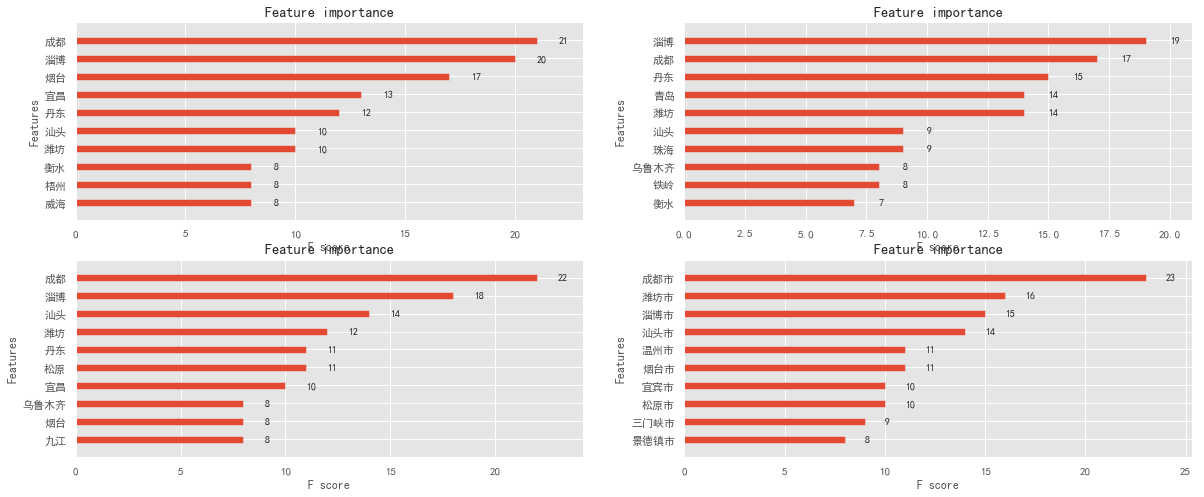

In [37]:
# 输出变量的重要性
from xgboost import plot_importance
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
plot_importance(xg_area1,ax=ax1,max_num_features=10,height=0.4)
plot_importance(xg_area2,ax=ax2,max_num_features=10,height=0.4)
plot_importance(xg_area3,ax=ax3,max_num_features=10,height=0.4)
plot_importance(xg_area4,ax=ax4,max_num_features=10,height=0.4)

In [38]:
# 城市变量的二值化
data1['is_zibo_UserInfo2'] = data1.apply(lambda x:1 if x.UserInfo_2=='淄博' else 0,axis=1)
data1['is_chengdu_UserInfo2'] = data1.apply(lambda x:1 if x.UserInfo_2=='成都' else 0,axis=1)
data1['is_yantai_UserInfo2'] = data1.apply(lambda x:1 if x.UserInfo_2=='烟台' else 0,axis=1)

data1['is_zibo_UserInfo4'] = data1.apply(lambda x:1 if x.UserInfo_4=='淄博' else 0,axis=1)
data1['is_chengdu_UserInfo4'] = data1.apply(lambda x:1 if x.UserInfo_4=='成都' else 0,axis=1)
data1['is_weifang_UserInfo4'] = data1.apply(lambda x:1 if x.UserInfo_4=='丹东' else 0,axis=1)

data1['is_zibo_UserInfo8'] = data1.apply(lambda x:1 if x.UserInfo_8=='淄博' else 0,axis=1)
data1['is_chengdu_UserInfo8'] = data1.apply(lambda x:1 if x.UserInfo_8=='成都' else 0,axis=1)
data1['is_shantou_UserInfo8'] = data1.apply(lambda x:1 if x.UserInfo_8=='汕头' else 0,axis=1)

data1['is_zibo_UserInfo20'] = data1.apply(lambda x:1 if x.UserInfo_20=='淄博市' else 0,axis=1)
data1['is_chengdu_UserInfo20'] = data1.apply(lambda x:1 if x.UserInfo_20=='成都市' else 0,axis=1)
data1['is_weifang_UserInfo20'] = data1.apply(lambda x:1 if x.UserInfo_20=='潍坊市' else 0,axis=1)

In [39]:
# 将四个城市变量改成同一的格式
data1['UserInfo_20'] = [i[:-1] if i.find('市')>0 else i[:] for i in data1.UserInfo_20]
# 城市变更次数变量衍生
city_df = data1[['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20']]
city_change_cnt =[]
for i in range(city_df.shape[0]):
    a = list(city_df.iloc[i])
    city_count = len(set(a))
    city_change_cnt.append(city_count)
data1['city_change_cnt'] = city_change_cnt
# 删除原变量
data1 = data1.drop(['UserInfo_2','UserInfo_4','UserInfo_8','UserInfo_20'],axis=1)
data1.shape

(49101, 173)

### 微博

In [42]:
# 将字符型的nan转为众数
for col in ['WeblogInfo_19','WeblogInfo_20','WeblogInfo_21']:
    data1 = data1.replace({col:{'nan':np.nan}})
# 将缺失填充为众数
for col in ['WeblogInfo_19','WeblogInfo_20','WeblogInfo_21']:
    data1[col] = data1[col].fillna(data1[col].mode()[0])

In [43]:
# 微博变量的哑变量处理
data1['WeblogInfo_19'] = ['WeblogInfo_19_'+s for s in data1.WeblogInfo_19]
data1['WeblogInfo_21'] = ['WeblogInfo_21_'+s for s in data1.WeblogInfo_21]

In [44]:
for col in ['WeblogInfo_19','WeblogInfo_21']:
    dummy_df = pd.get_dummies(data1[col])
    data1 = pd.concat([data1,dummy_df],axis=1)
# 删除原变量
data1 = data1.drop(['WeblogInfo_19','WeblogInfo_21','WeblogInfo_20'],axis=1)
data1.shape

(49101, 181)

## 数值型变量 

In [46]:
# 数值型变量的缺失率分布
len(num)

138

In [48]:
# 数值型变量的描述性分析
num_desc = data1.loc[:,num].describe().T.assign(nuniq = data1.loc[:,num].apply(lambda x:x.nunique()),\
                                         misssing_pct  =data1.loc[:,num].apply(lambda x:(len(x)-x.count())/len(x)))\
                              .sort_values('nuniq')
num_desc.head(10)

,count,mean,std,min,25%,50%,75%,max,nuniq,misssing_pct
target,49101.0,0.074418,0.262453,0.0,0.0,0.0,0.0,1.0,2,0.000000
UserInfo_17,49101.0,1.126087,0.331951,1.0,1.0,1.0,1.0,2.0,2,0.000000
UserInfo_13,18204.0,0.641233,0.479652,0.0,0.0,1.0,1.0,1.0,2,0.629254
UserInfo_12,18204.0,0.357119,0.479164,0.0,0.0,0.0,1.0,1.0,2,0.629254
UserInfo_11,18204.0,0.085586,0.279759,0.0,0.0,0.0,0.0,1.0,2,0.629254
UserInfo_10,49101.0,0.311379,0.604031,0.0,0.0,0.0,0.0,2.0,3,0.000000
UserInfo_5,49101.0,1.649824,0.583149,1.0,1.0,2.0,2.0,3.0,3,0.000000
UserInfo_6,49101.0,1.649926,0.581899,1.0,1.0,2.0,2.0,3.0,3,0.000000
SocialNetwork_12,49101.0,-0.744995,0.441163,-1.0,-1.0,-1.0,0.0,1.0,3,0.000000
SocialNetwork_17,49101.0,0.253620,0.437282,0.0,0.0,0.0,1.0,3.0,4,0.000000


### 排序特征衍生 

In [50]:
num_col2 = [col for col in num if col!='target']
# 筛选出只有数值型变量的数据集
num_data = data1.loc[:,num_col2]

# 排序特征衍生
for col in num_col2:
    num_data['rank'+col] = num_data[col].rank(method='max')/num_data.shape[0]

# 将排序特征转为单独的数据集
rank_col = [col for col in num_data.columns if col not in num_col2]
rank_df = num_data.loc[:,rank_col]

### periods变量衍生 

In [51]:
# 生成只包含periods的临时表
periods_col = [i for i in num_col2 if i.find('Period')>0]
periods_col2 = periods_col+['target']
periods_data = data1.loc[:,periods_col2]

In [52]:
# 观察包含period1所有字段的数据，发现字段之间量级差异比较大，可能代表不同的含义，不适合做衍生
periods1_col = [col for col in periods_col if col.find('Period1')>0]
periods_data.loc[:,periods1_col].head()

,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9
0,10,1,10,63,27489,0,18900,6083,2506,47,167,0,25,65,68,34,2
1,0,1,8,0,3839,9558,49,9571,3777,0,68,105,40,2,132,39,2
2,1,0,7,0,3578,5360,0,4646,4292,2,50,50,49,0,78,22,0
3,9,1,9,0,3805,9765,0,10461,3109,54,56,125,38,0,136,45,2
4,1,1,5,0,561,792,1353,0,0,5,39,34,36,73,0,0,1


In [53]:
# 观察后缀都为1的字段，发现字段数据的量级基本一致，可以对其做min,max,avg等统计值的衍生
period_1_col=[]
for i in range(0,102,17):
    col = periods_col[i]
    period_1_col.append(col)
periods_data.loc[:,period_1_col].head()

,ThirdParty_Info_Period1_1,ThirdParty_Info_Period2_1,ThirdParty_Info_Period3_1,ThirdParty_Info_Period4_1,ThirdParty_Info_Period5_1,ThirdParty_Info_Period6_1
0,10,25,36,4,0,0
1,0,7,1,0,0,-1
2,1,0,1,14,1,0
3,9,6,2,25,9,11
4,1,8,3,0,0,-1


In [54]:
p_num_col=[]
# 将Period变量按照后缀数字存储成嵌套列表
for i in range(0,17,1):
    p_col=[]
    for j in range(i,102,17):
        col = periods_col[j]
        p_col.append(col)
    p_num_col.append(p_col)

In [55]:
# min,max,avg等统计值的衍生，并将衍生后的特征存成单独的数据集
periods_data = periods_data.fillna(0)
periods_fea_data=pd.DataFrame()
for j,p_list in zip(range(1,18,1),p_num_col):
    p_data = periods_data.loc[:,p_list]
    period_min=[]
    period_max=[]
    period_avg=[]
    for i in range(periods_data.shape[0]):
        a = p_data.iloc[i]
        period_min.append(np.min(a))
        period_max.append(np.max(a))
        period_avg.append(np.average(a))
    periods_fea_data['periods_'+str(j)+'_min'] = period_min
    periods_fea_data['periods_'+str(j)+'_max'] = period_max
    periods_fea_data['periods_'+str(j)+'_avg'] = period_avg

------

In [56]:
# 保存特征衍生后的数据集至本地
data1.to_csv(path+'/data1_process.csv',encoding='gb18030',index=False)
rank_df.to_csv(path + '/rank_feature.csv',encoding='gbk',index=False)
periods_fea_data.to_csv(path+'/periods_feature.csv',encoding='gbk',index=False)

# 修改信息表

In [57]:
df2 = pd.read_csv(path+'/data_input2.csv',encoding='gbk')

In [58]:
# 最近的修改时间距离成交时间差
# 时间格式的转换
df2['ListingInfo1'] = pd.to_datetime(df2['ListingInfo1'])
df2['UserupdateInfo2'] = pd.to_datetime(df2['UserupdateInfo2'])

In [59]:
# 计算时间差
time_span = df2.groupby('Idx',as_index=False).agg({'UserupdateInfo2':np.max,
                                                   'ListingInfo1':np.max})
time_span['update_timespan'] = time_span['ListingInfo1']-time_span['UserupdateInfo2']
time_span['update_timespan'] = time_span['update_timespan'].map(lambda x:str(x))
time_span['update_timespan'] = time_span['update_timespan'].map(lambda x:int(x[:x.find('d')]))
time_span = time_span[['Idx','update_timespan']]

In [60]:
# 将UserupdateInfo1里的字符改为小写形式
df2['UserupdateInfo1'] = df2.UserupdateInfo1.map(lambda x:x.lower())
# 根据Idx计算UserupdateInfo2的非重复计数
group = df2.groupby(['Idx','UserupdateInfo1'],as_index=False).agg({'UserupdateInfo2':pd.Series.nunique})

In [61]:
# 每种信息修改的次数的衍生
user_df_list=[]
for idx in group.Idx.unique():
    user_df  = group[group.Idx==idx]
    change_cate = list(user_df.UserupdateInfo1)
    change_cnt = list(user_df.UserupdateInfo2)
    user_col  = ['Idx']+change_cate
    user_value = [user_df.iloc[0]['Idx']]+change_cnt
    user_df2 = pd.DataFrame(np.array(user_value).reshape(1,len(user_value)),columns=user_col)
    user_df_list.append(user_df2)
cate_change_df = pd.concat(user_df_list,axis=0)
cate_change_df.head()

,Idx,_age,_bussinessaddress,_byuserid,_cityid,_companyaddress,_companyname,_companyphone,_companysizeid,_companytypeid,...,_residencetypeid,_residenceyears,_schoolname,_secondemail,_secondmobile,_turnover,_userid,_webshoptypeid,_webshopurl,_workyears
0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# 将cate_change_df里的空值填为0
cate_change_df = cate_change_df.fillna(0)
cate_change_df.shape

(49993, 56)

In [63]:
# 修改信息的总次数，按照日期修改的次数的衍生
update_cnt = df2.groupby('Idx',as_index=False).agg({'UserupdateInfo2':pd.Series.nunique,
                                                         'ListingInfo1':pd.Series.count}).\
                      rename(columns={'UserupdateInfo2':'update_time_cnt',
                                      'ListingInfo1':'update_all_cnt'})
#update_cnt.head()

In [64]:
# 将三个衍生特征的临时表进行关联
update_info = pd.merge(time_span,cate_change_df,on='Idx',how='left')
update_info = pd.merge(update_info,update_cnt,on='Idx',how='left')
#update_info.head()

In [65]:
# 保存数据至本地
update_info.to_csv(path + '/update_feature.csv',encoding='gbk',index=False)

#  登录信息表

In [3]:
df3 = pd.read_csv(path+'/data_input3.csv',encoding='gb18030')

In [4]:
# 累计登录次数
log_cnt = df3.groupby('Idx',as_index=False).LogInfo3.count().rename(
    columns={'LogInfo3':'log_cnt'})
#log_cnt.head()

In [5]:
# 最近一次的登录时间距离当前时间差
df3['Listinginfo1']=pd.to_datetime(df3.Listinginfo1)
df3['LogInfo3'] = pd.to_datetime(df3.LogInfo3)
time_log_span = df3.groupby('Idx',as_index=False).agg({'Listinginfo1':np.max,
                                                       'LogInfo3':np.max})
time_log_span['log_timespan'] = time_log_span['Listinginfo1']-time_log_span['LogInfo3']
time_log_span['log_timespan'] = time_log_span['log_timespan'].map(lambda x:str(x))
time_log_span['log_timespan'] = time_log_span['log_timespan'].map(lambda x:int(x[:x.find('d')]))
time_log_span= time_log_span[['Idx','log_timespan']]
#time_log_span.head()

In [6]:
# 登录时间的平均时间间隔
df4  = df3.sort_values(by=['Idx','LogInfo3'],ascending=['True','True'])

In [7]:
df4['LogInfo4'] = df4.groupby('Idx')['LogInfo3'].apply(lambda x:x.shift(1))

In [8]:
df4['time_span'] = df4['LogInfo3']-df4['LogInfo4']
df4['time_span'] = df4['time_span'].map(lambda x:str(x))
df4 = df4.replace({'time_span':{'NaT':'0 days 00:00:00'}})
df4['time_span'] = df4['time_span'].map(lambda x:int(x[:x.find('d')]))

In [9]:
avg_log_timespan = df4.groupby('Idx',as_index=False).time_span.mean().rename(columns={'time_span':'avg_log_timespan'})
#avg_log_timespan.head()

In [10]:
log_info = pd.merge(log_cnt,time_log_span,how='left',on='Idx')
log_info = pd.merge(log_info,avg_log_timespan,how='left',on='Idx')
#log_info.head()

In [11]:
log_info.to_csv(path + '/log_info_feature.csv',encoding='gbk',index=False)